# INIT

In [36]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Imports

In [37]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

### Figure parameters

In [38]:
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 15
figsize = [30, 15]

### Methods

In [39]:
def FileCheck(fn):
    try:
        open(fn, "r")
        return True
    except IOError:
#         print("Error: File does not appear to exist.")
        return False

In [40]:
def getReps(folder):
    fn = folder + "experiment.json"
#     if FileCheck(fn):
#         with open (fn) as json_file:
#             try:
#                 experimentInfo = json.load(json_file)
#                 return experimentInfo["repetitions"]
#             except:
#                 pass

    i = 0
    while(True):
        fn = folder + "MO_info" + str(i) + ".json"
        if not FileCheck(fn):
            return i
        i = i + 1
        
        
def findMaxEvalsLength(folder, evalType, reps):
    maxEvalsLength = 0
    for i in range(reps):
        fn = folder + "MO_info" + str(i) + ".json"
        with open(fn) as json_file:
            data = json.load(json_file)
            maxEvalsLength = max(maxEvalsLength, len(data["changes_on_interval"][evalType]["evals"]))
    return maxEvalsLength

def generateSummaryFiles(folder):
    reps = getReps(folder)
    datapoints = 200
    
    changes_on_interval = {}
        
    for evalType in ["unique_evals", "total_evals"]:  
        evals = []
        np_avg_dist = np.zeros([reps, datapoints])
        np_max_dist = np.zeros([reps, datapoints])
        for i in range(reps):
            fn = folder + "MO_info" + str(i) + ".json"
            with open(fn) as json_file:
                data = json.load(json_file)
                data = data["changes_on_interval"][evalType]
                
                np_avg_dist[i, :len(data["avg_dist"])] = data["avg_dist"]
                np_avg_dist[i, len(data["avg_dist"]):] = data["avg_dist"][-1] # Fill the rest with the last recorded distance value
                np_max_dist[i, :len(data["max_dist"])] = data["max_dist"]
                np_max_dist[i, len(data["max_dist"]):] = data["max_dist"][-1] # Fill the rest with the last recorded distance value

                if len(data["evals"]) > len(evals):
                    evals = data["evals"]
        
        until = len(evals)
        np_avg_dist = np_avg_dist[:, :until]
        np_max_dist = np_max_dist[:, :until]
        
        np_avg_dist_mean = np.mean(np_avg_dist, 0)
        np_avg_dist_std = np.std(np_avg_dist, 0)
        np_avg_dist_min = np.amin(np_avg_dist, 0)
        np_avg_dist_max = np.amax(np_avg_dist, 0)
        
        np_max_dist_mean = np.mean(np_max_dist, 0)
        np_max_dist_std = np.std(np_max_dist, 0)
        np_max_dist_min = np.amin(np_max_dist, 0)
        np_max_dist_max = np.amax(np_max_dist, 0)
        
        
        evalJSON = {}
        evalJSON["evals"] = evals
        evalJSON["avg_dist"] = list(np_avg_dist_mean)
        evalJSON["avg_dist_std"] = list(np_avg_dist_std)
        evalJSON["avg_dist_min"] = list(np_avg_dist_min)
        evalJSON["avg_dist_max"] = list(np_avg_dist_max)
        evalJSON["max_dist"] = list(np_max_dist_mean)
        evalJSON["max_dist_std"] = list(np_max_dist_std)
        evalJSON["max_dist_min"] = list(np_max_dist_min)
        evalJSON["max_dist_max"] = list(np_max_dist_max)
        changes_on_interval[evalType] = evalJSON
        
    outfile = folder + "MO_info_average.json"
    with open(outfile, 'w') as outfile:
        json.dump(changes_on_interval, outfile)
            

In [41]:
# # def getColor(folder):
#     if "NSGA-II" in folder:
#         return "blue"
#     elif "RandomSearch" in folder:
#         return "orange"
#     elif "MO-GOMEA" in folder:
#         return 

In [42]:
def plotty(axis, folder, label, evalType, distType="avg", std=False, minmax=False, color=""):
    fn = folder + "MO_info_average.json"
    if not FileCheck(fn):
        print("Generating summary file")
        generateSummaryFiles(folder)
        
#     print(getColor(folder))
        
    with open(fn) as json_file:
        data = json.load(json_file)
        data = data[evalType]
        Y = data[distType+"_dist"]
        X = data["evals"]
        
        if color is "":
            if(std):
                axis.errorbar(X, Y, yerr=data[distType+"_dist_std"], label=label)
            else:
                axis.plot(X, Y, label=label)
                if(minmax):
                    axis.fill_between(X, data[distType+"_dist_min"], data[distType+"_dist_max"], alpha=0.1)
        else:
#             color = getColor(folder)
#             print(color)
            if(std):
                axis.errorbar(X, Y, yerr=data[distType+"_dist_std"], label=label, color=color)
            else:
                axis.plot(X, Y, label=label, color=color)
                if(minmax):
                    axis.fill_between(X, data[distType+"_dist_min"], data[distType+"_dist_max"], color=color, alpha=0.1)
    

# MO-GOMEA

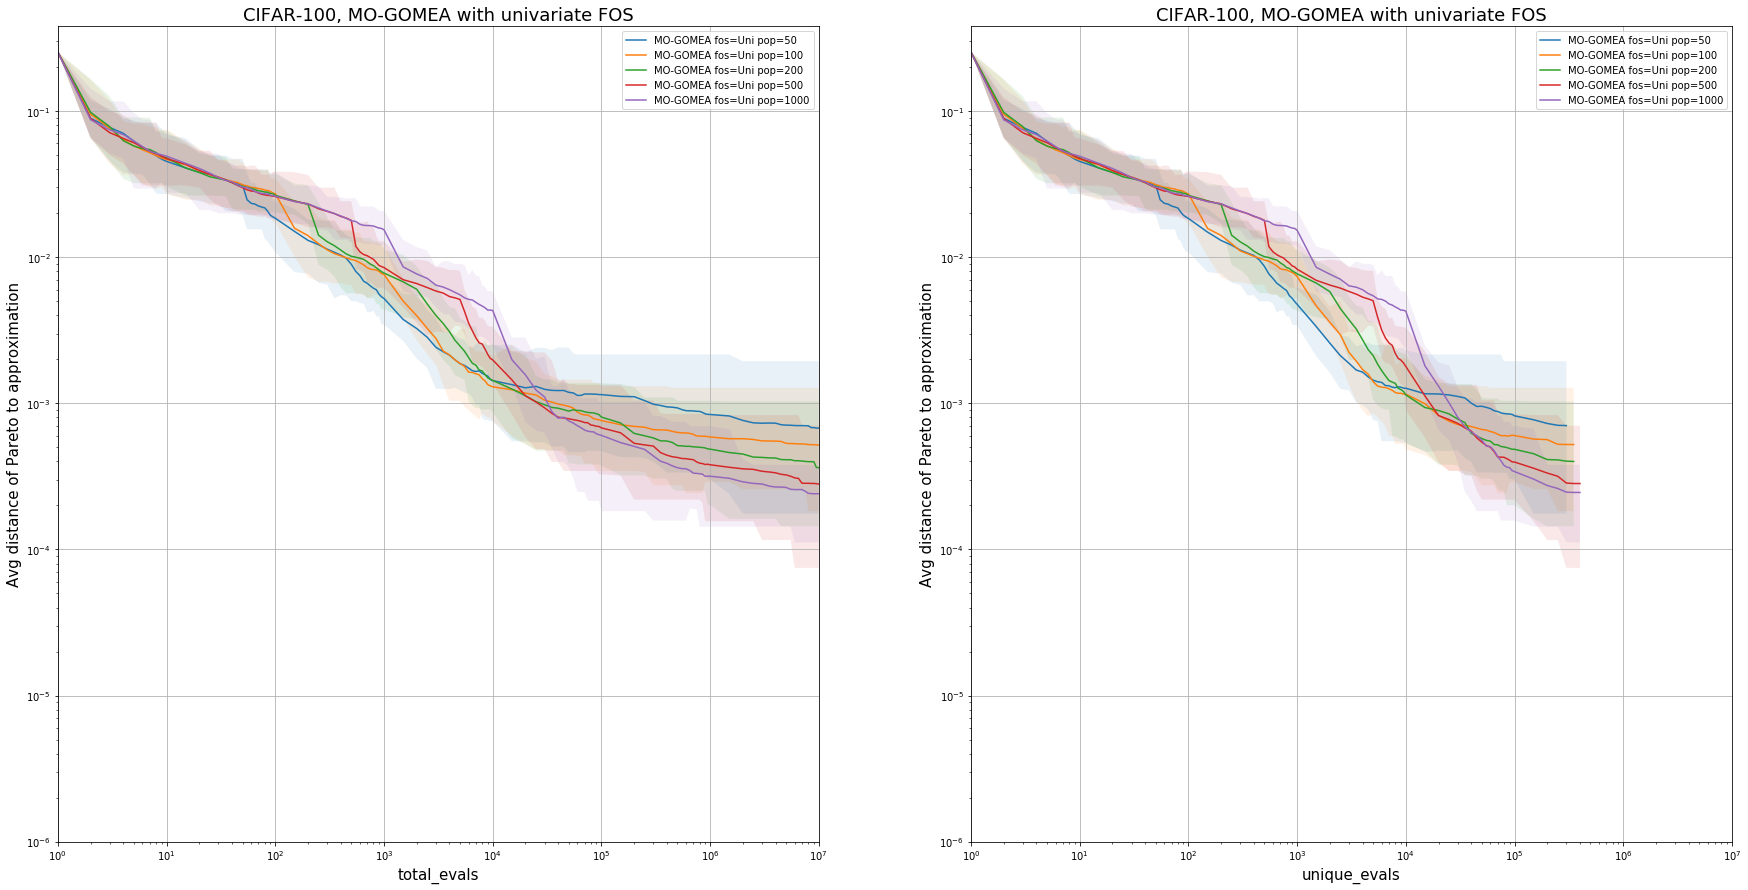

In [43]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, evalType in enumerate(["total_evals", "unique_evals"]):
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    for popsize in ["50", "100", "200", "500", "1000"]:
        plotty(ax[i], "../data/exp18/ARK-7-MO_MO_GOMEA_unirand_pop" + popsize + "/", "MO-GOMEA fos=Uni pop=" + popsize, evalType, std=False, minmax=True)

    ax[i].set_title("CIFAR-100, MO-GOMEA with univariate FOS")
    ax[i].set_xlabel(evalType)
    ax[i].set_ylabel("Avg distance of Pareto to approximation")
    ax[i].set_ylim(pow(10, -6))
    ax[i].set_xlim(1, pow(10, 7))
    ax[i].grid()
    ax[i].legend()


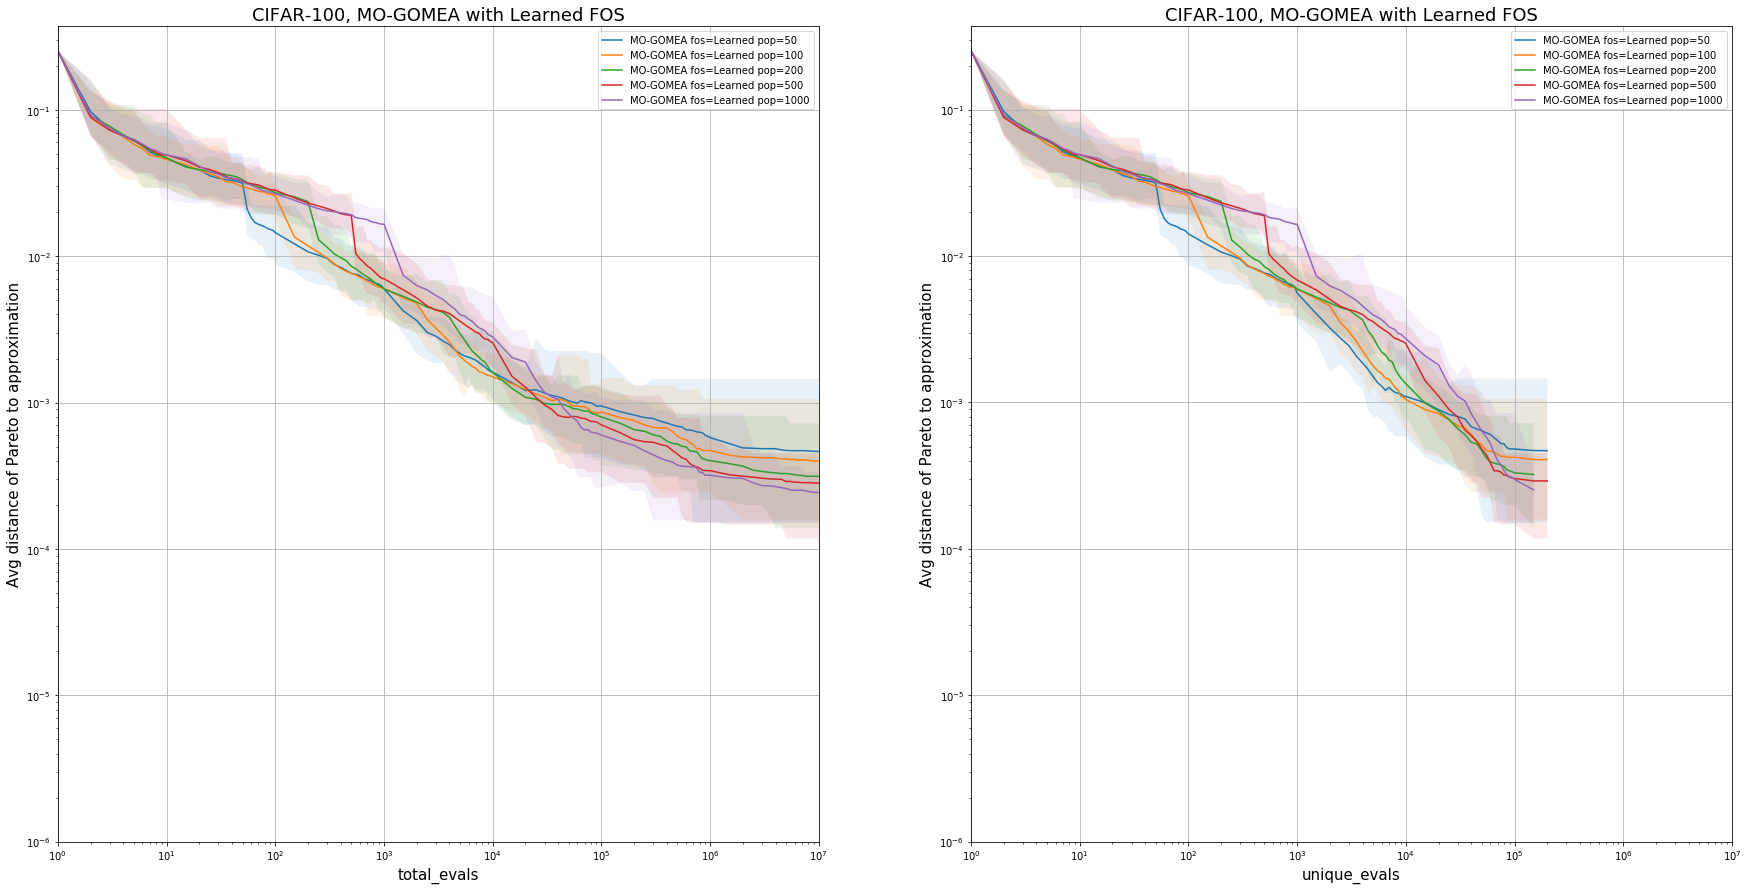

In [44]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, evalType in enumerate(["total_evals", "unique_evals"]):
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    for popsize in ["50", "100", "200", "500", "1000"]:
        plotty(ax[i], "../data/exp18/ARK-7-MO_MO_GOMEA_learnedLT_pop" + popsize + "/", "MO-GOMEA fos=Learned pop=" + popsize, evalType, std=False, minmax=True)

    ax[i].set_title("CIFAR-100, MO-GOMEA with Learned FOS")
    ax[i].set_xlabel(evalType)
    ax[i].set_ylabel("Avg distance of Pareto to approximation")
    ax[i].set_ylim(pow(10, -6))
    ax[i].set_xlim(1, pow(10, 7))
    ax[i].grid()
    ax[i].legend()


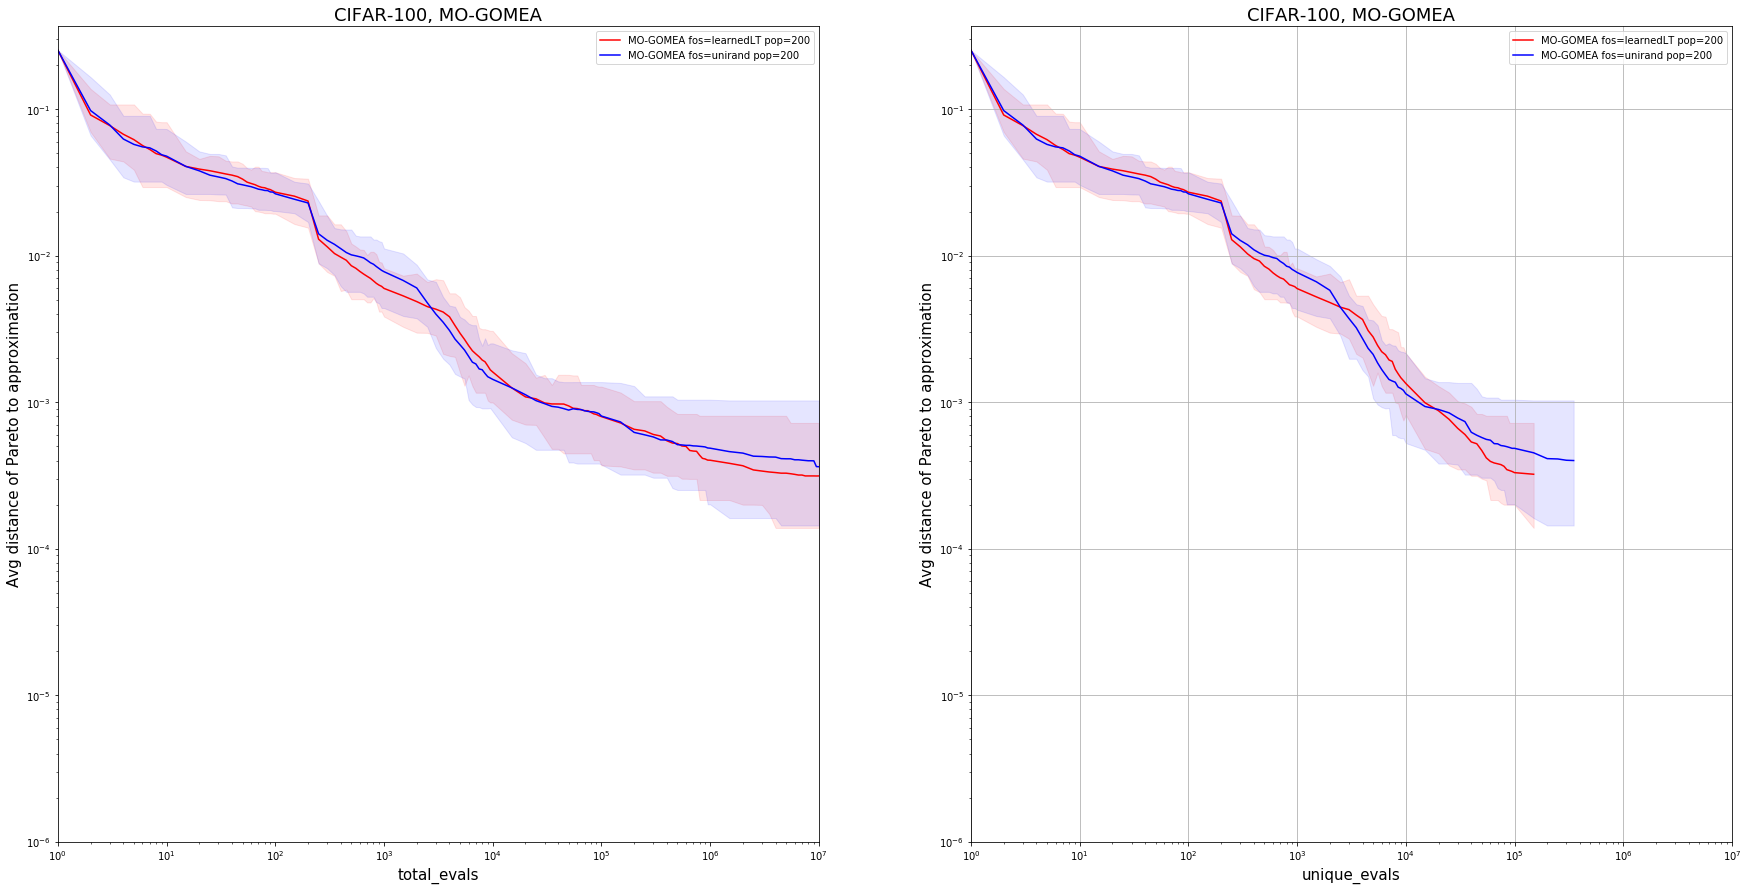

In [46]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, evalType in enumerate(["total_evals", "unique_evals"]):
    for fos in ["learnedLT", "unirand"]:
        if fos is "learnedLT":
            color = "red"
        else:
            color = "blue"
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")
        for popsize in ["200"]: #, "100", "200", "500", "1000"]:
            plotty(ax[i], "../data/exp18/ARK-7-MO_MO_GOMEA_" + fos + "_pop" + popsize + "/", "MO-GOMEA fos="+fos+" pop=" + popsize, evalType, color=color, minmax=True)

        ax[i].set_title("CIFAR-100, MO-GOMEA")
        ax[i].set_xlabel(evalType)
        ax[i].set_ylabel("Avg distance of Pareto to approximation")
        ax[i].set_ylim(pow(10, -6))
        ax[i].set_xlim(1, pow(10, 7))
        ax[i].grid()
        ax[i].legend()
        
ax[1].grid()


# MO LOCAL SEARCH

## CIFAR-10

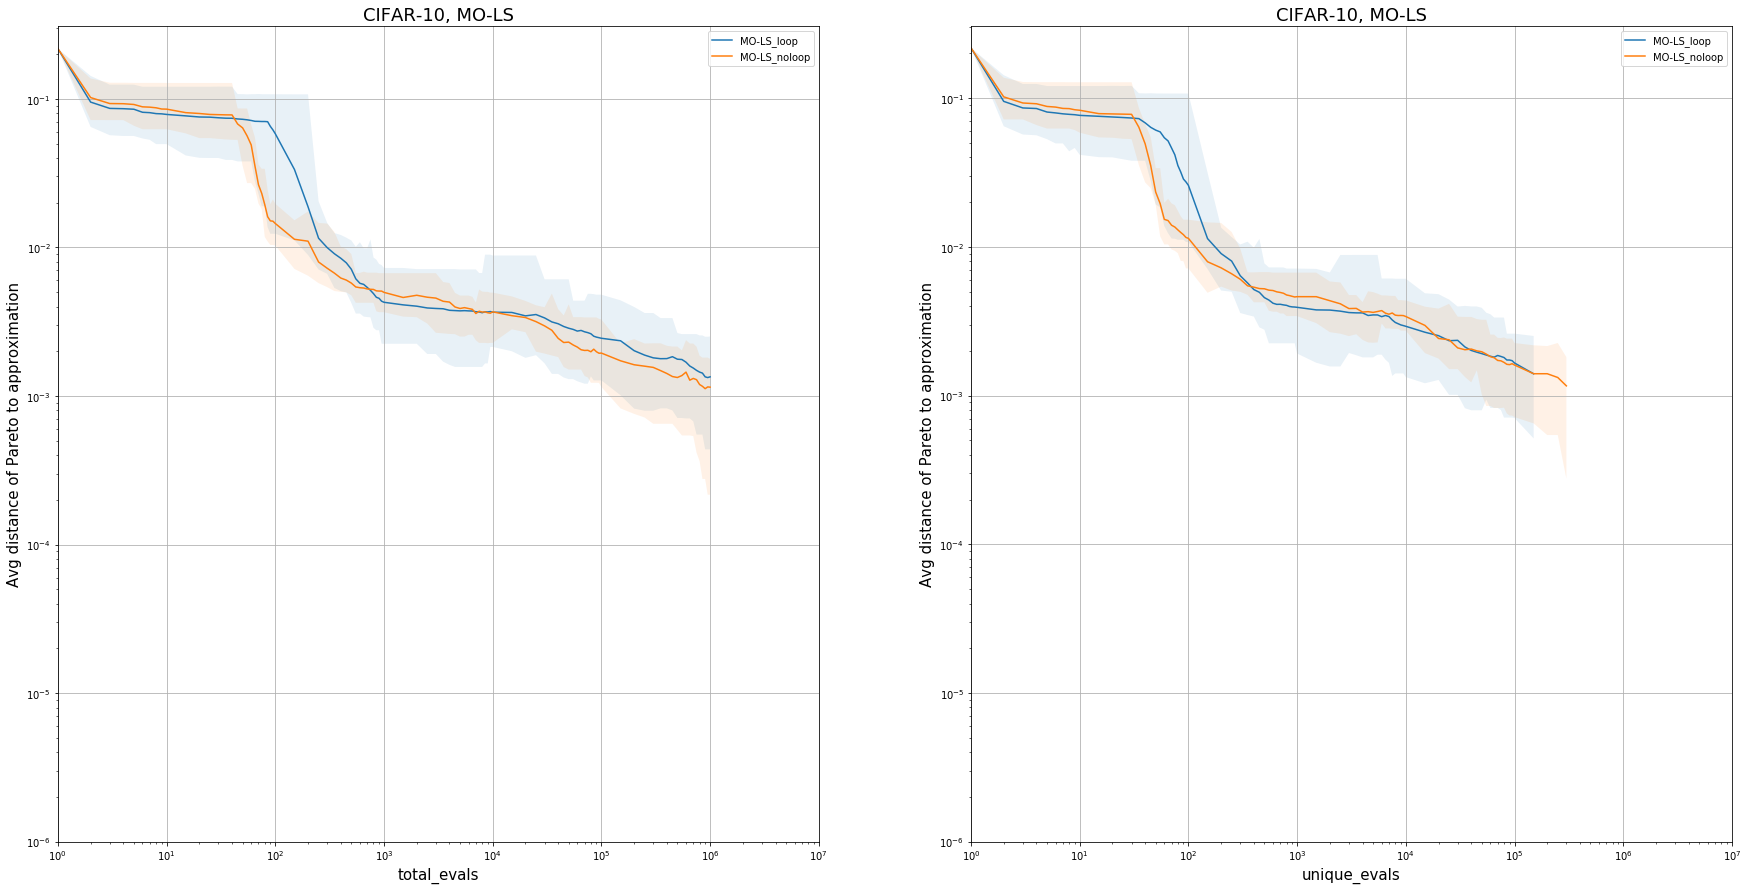

In [47]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, evalType in enumerate(["total_evals", "unique_evals"]):
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    popsize = 100
    for loop in ["loop", "noloop"]:
        plotty(ax[i], "../data/exp19/ARK-8-MO_MO-LS_" + loop + "/", "MO-LS_" + loop, evalType, std=False, minmax=True)

    ax[i].set_title("CIFAR-10, MO-LS")
    ax[i].set_xlabel(evalType)
    ax[i].set_ylabel("Avg distance of Pareto to approximation")
    ax[i].set_ylim(pow(10, -6))
    ax[i].set_xlim(1, pow(10, 7))
    ax[i].grid()
    ax[i].legend()

## CIFAR-100

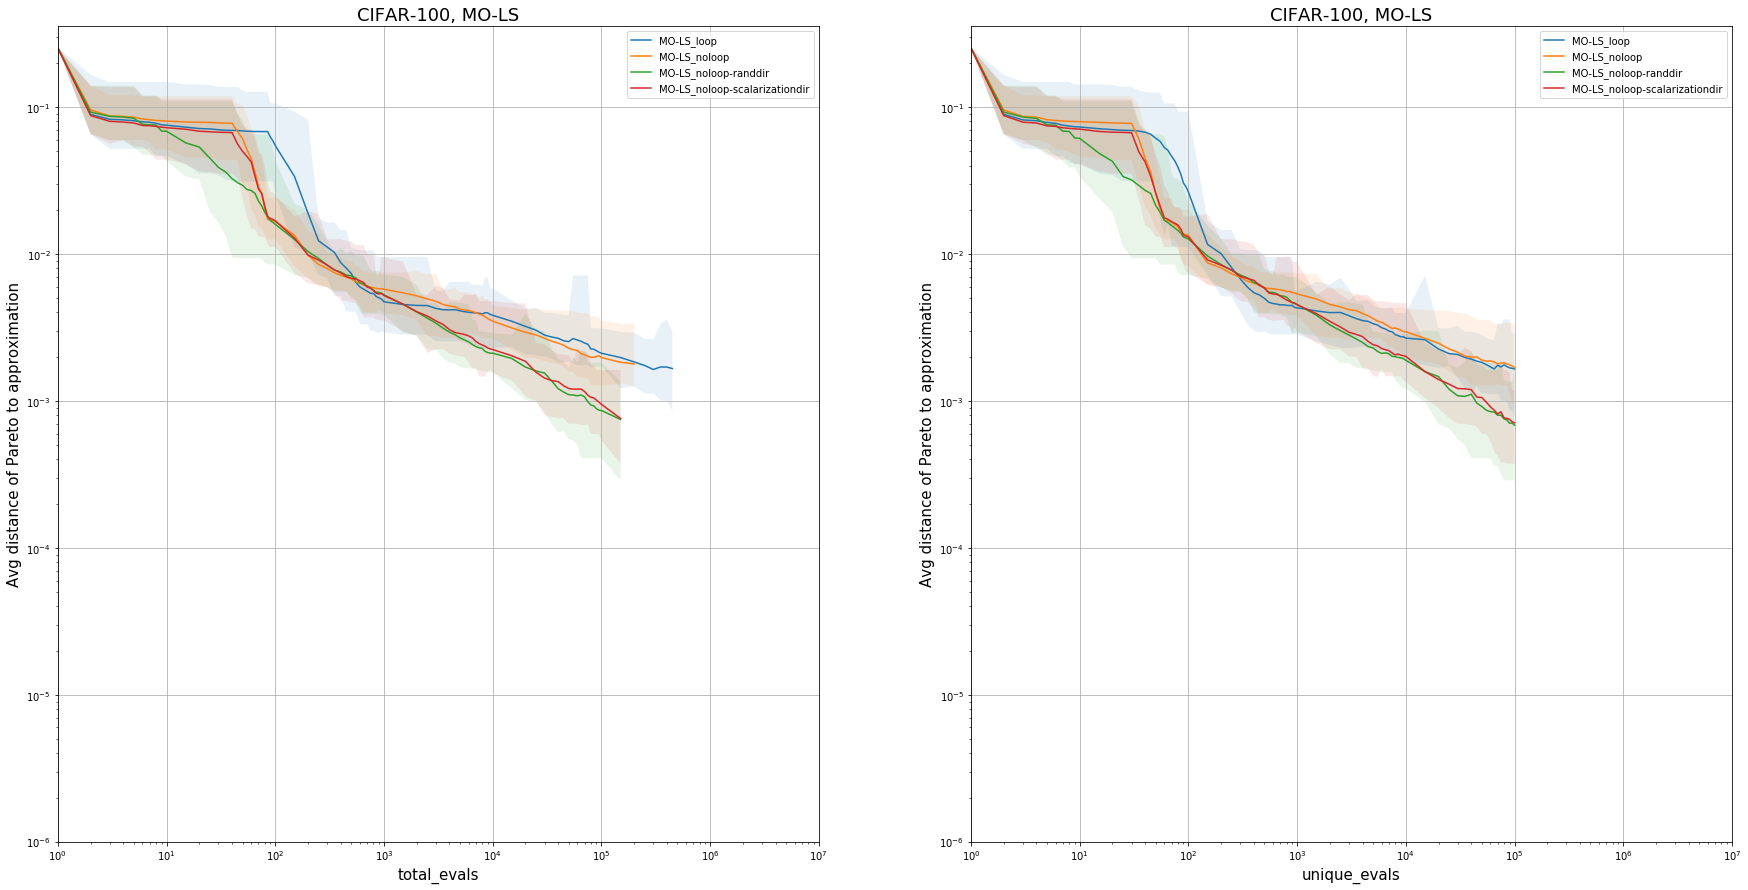

In [48]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, evalType in enumerate(["total_evals", "unique_evals"]):
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    popsize = 100
    for suffix in ["loop", "noloop", "noloop-randdir", "noloop-scalarizationdir"]:
        plotty(ax[i], "../data/exp18/ARK-7-MO_MO-LS-" + suffix + "/", "MO-LS_" + suffix, evalType, std=False, minmax=True)

    ax[i].set_title("CIFAR-100, MO-LS")
    ax[i].set_xlabel(evalType)
    ax[i].set_ylabel("Avg distance of Pareto to approximation")
    ax[i].set_ylim(pow(10, -6))
    ax[i].set_xlim(1, pow(10, 7))
    ax[i].grid()
    ax[i].legend()

# NSGA-II

## 2-point crossover, different population sizes

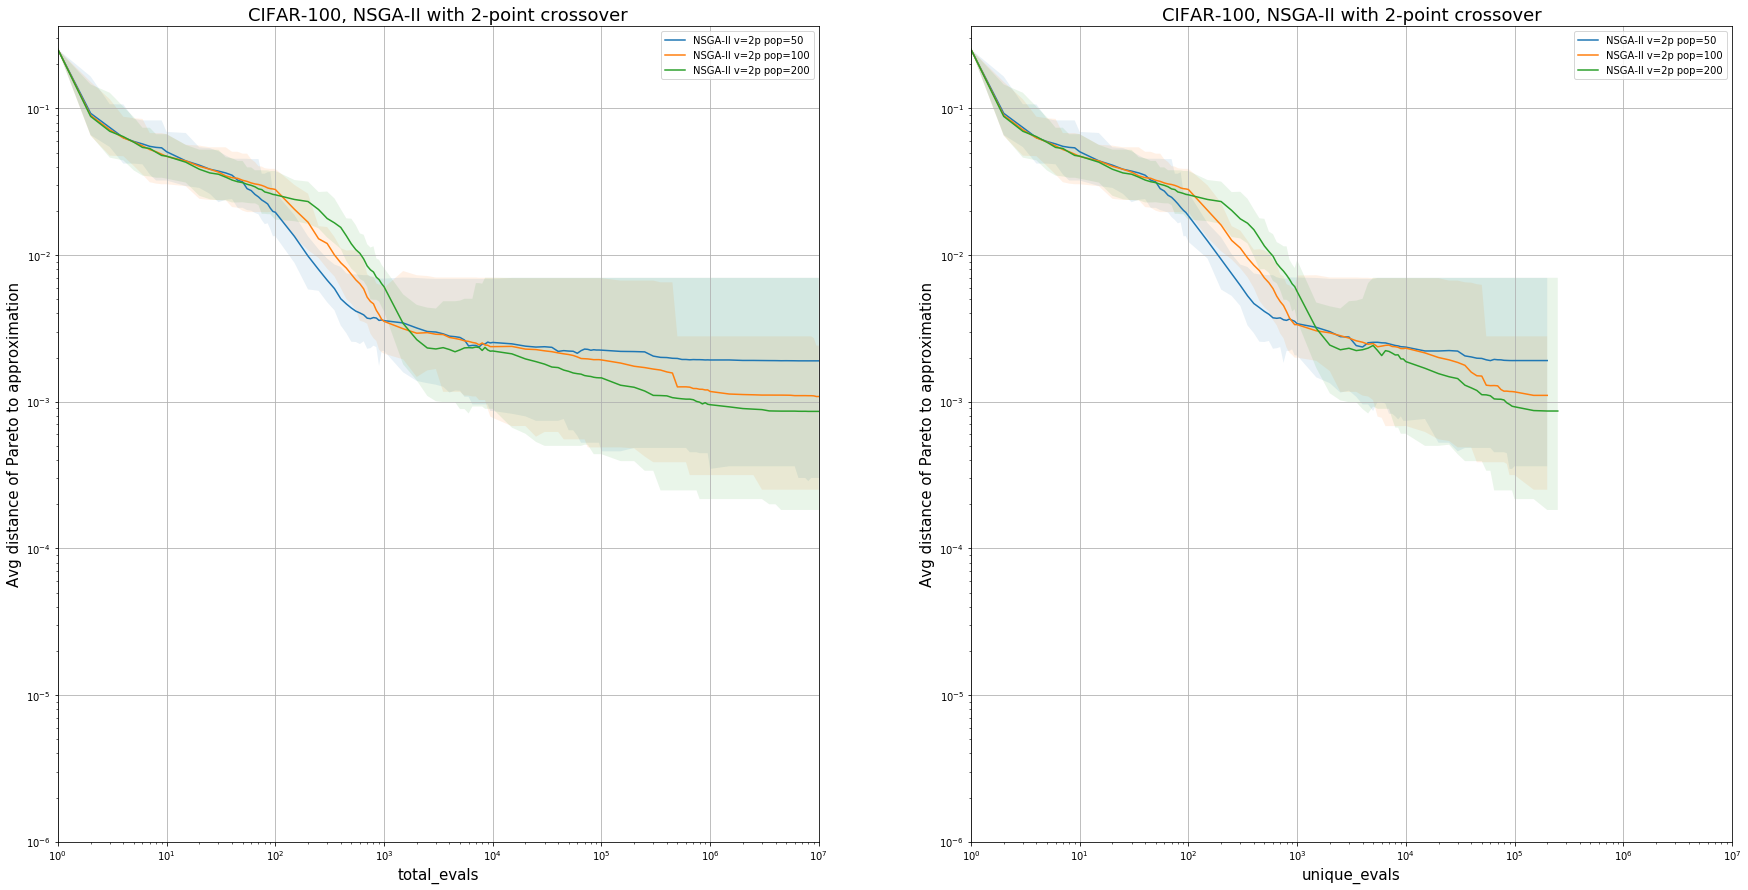

In [50]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, evalType in enumerate(["total_evals", "unique_evals"]):
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    for popsize in ["50", "100", "200"]:
        plotty(ax[i], "../data/exp18/ARK-7-MO_NSGA-II_xo=2p_pop" + popsize + "/", "NSGA-II v=2p pop=" + popsize, evalType, std=False, minmax=True)

    ax[i].set_title("CIFAR-100, NSGA-II with 2-point crossover")
    ax[i].set_xlabel(evalType)
    ax[i].set_ylabel("Avg distance of Pareto to approximation")
    ax[i].set_ylim(pow(10, -6))
    ax[i].set_xlim(1, pow(10, 7))
    ax[i].grid()
    ax[i].legend()

## Different crossovers for different popsizes

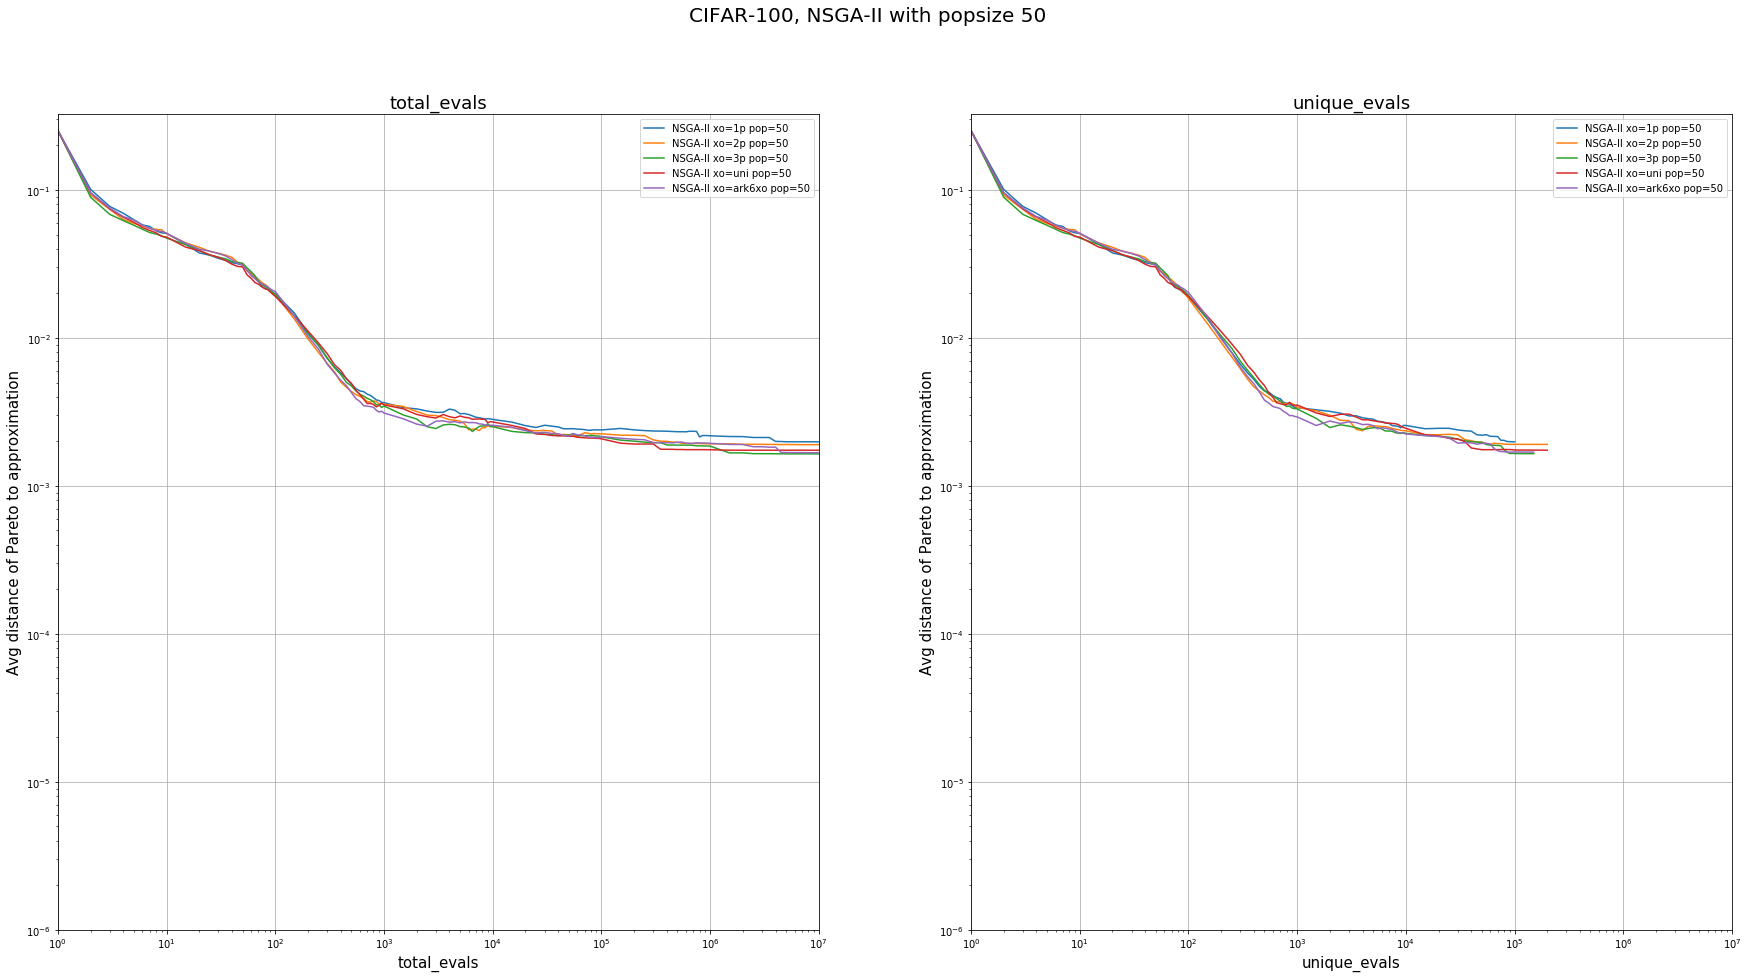

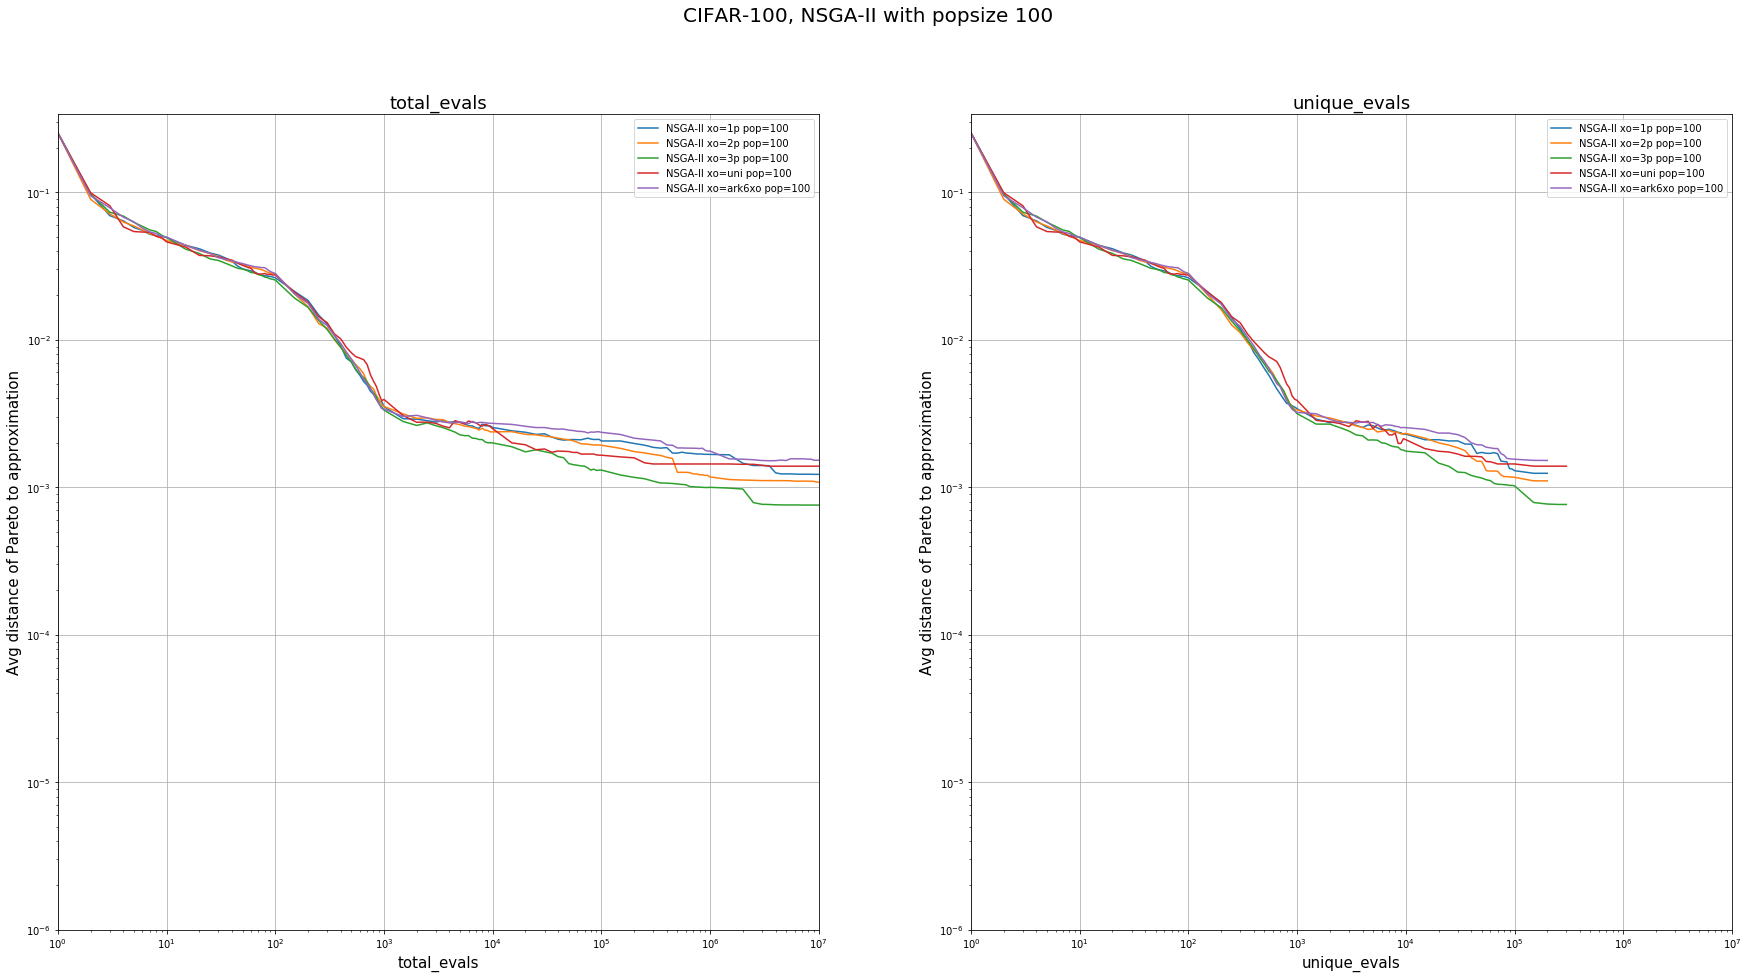

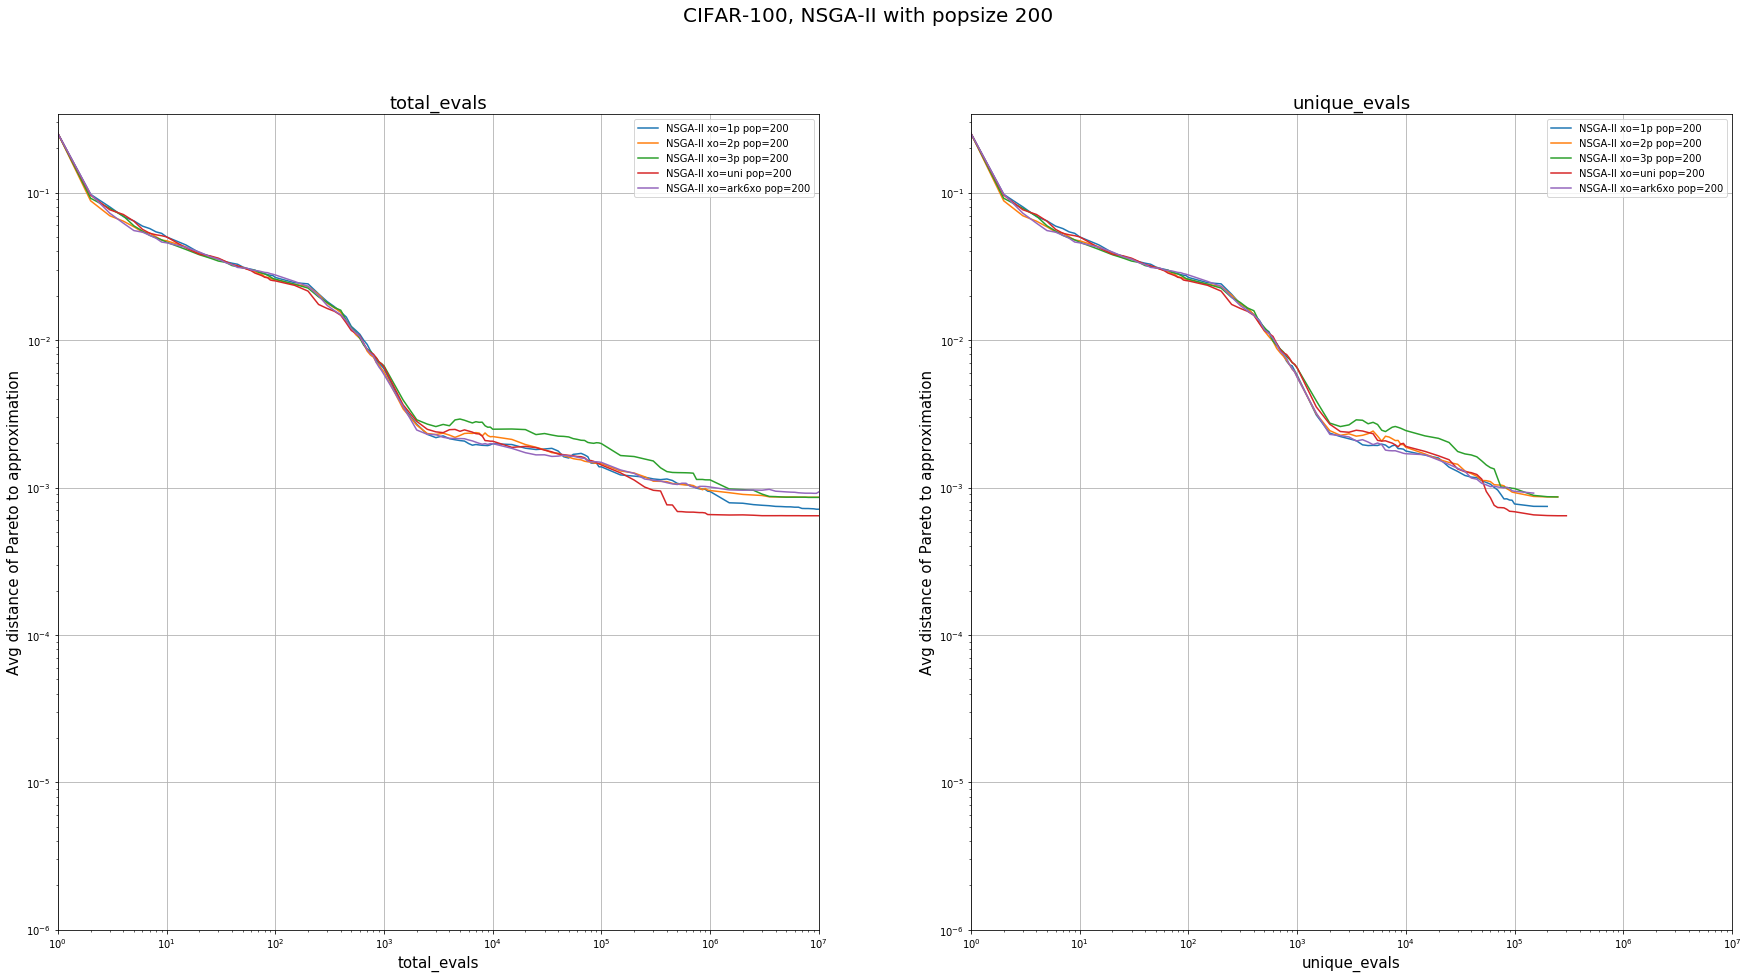

In [51]:
for popsize in ["50", "100", "200"]:
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i, evalType in enumerate(["total_evals", "unique_evals"]):
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")
        for xo in ["1p", "2p", "3p", "uni", "ark6xo"]:
            plotty(ax[i], "../data/exp18/ARK-7-MO_NSGA-II_xo=" + xo + "_pop" + popsize + "/", "NSGA-II xo="+xo+" pop=" + popsize, evalType)

        ax[i].set_title(evalType)
        ax[i].set_xlabel(evalType)
        ax[i].set_ylabel("Avg distance of Pareto to approximation")
        ax[i].set_ylim(pow(10, -6))
        ax[i].set_xlim(1, pow(10, 7))
        ax[i].grid()
        ax[i].legend()
    fig.suptitle("CIFAR-100, NSGA-II with popsize " + popsize)
    

# Plots of multiple algorithms

## Initial

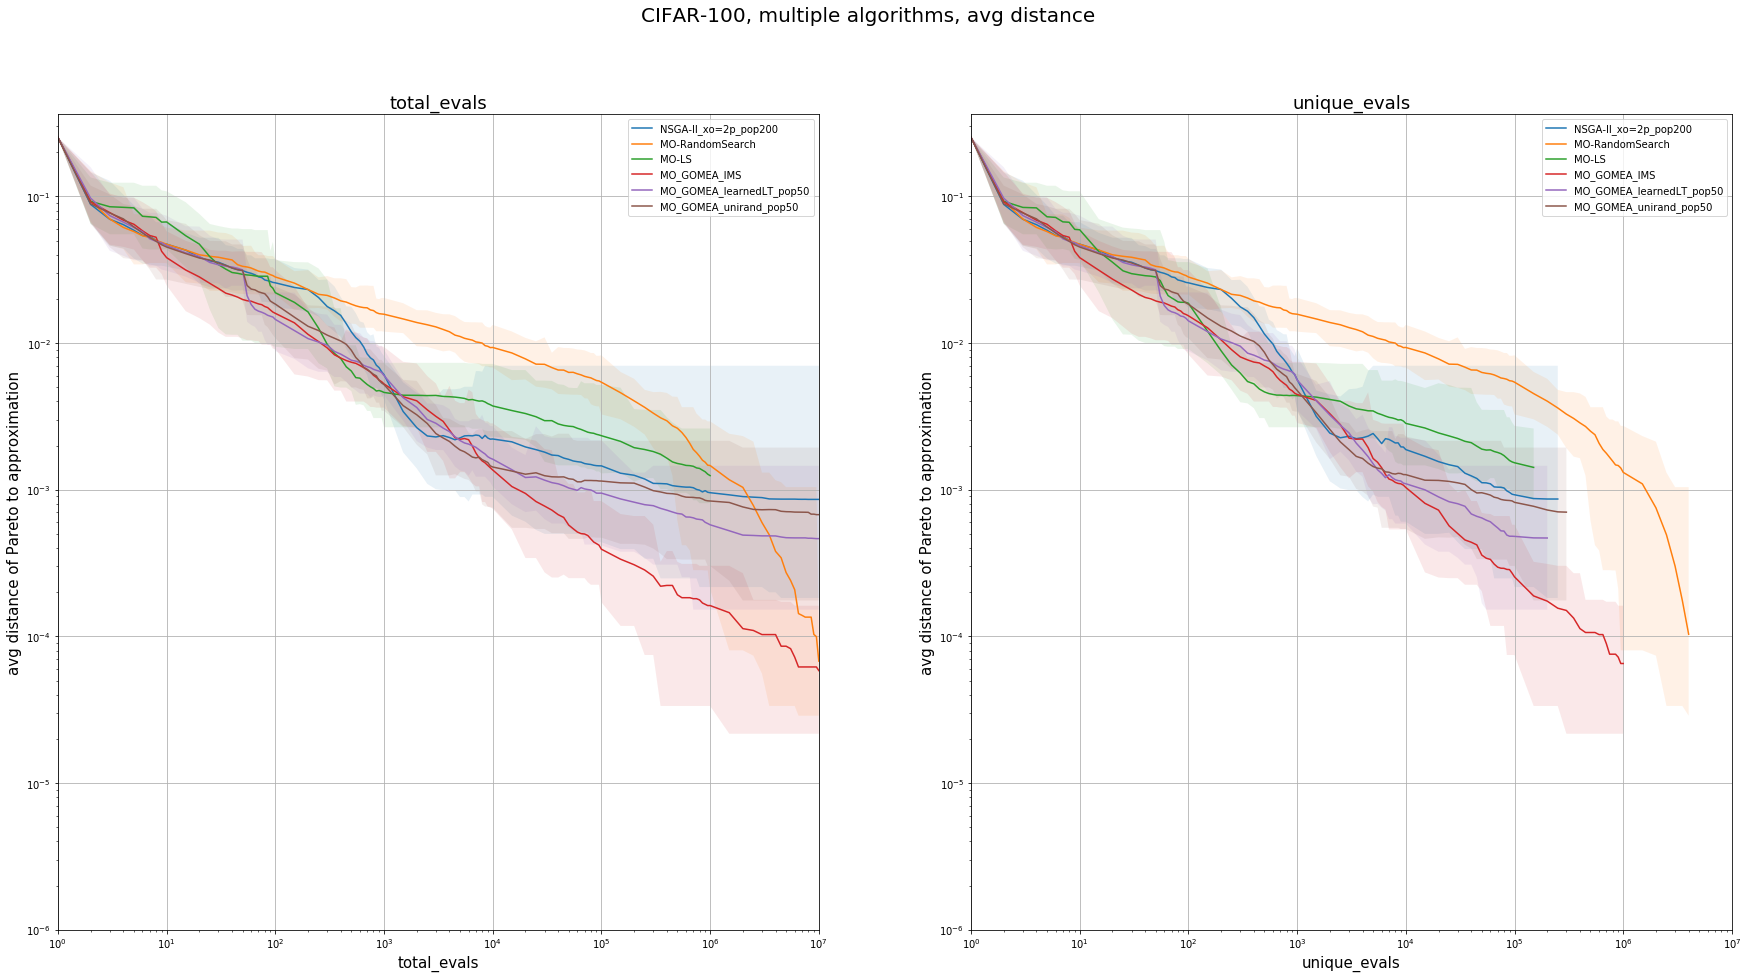

In [52]:
algos = ["NSGA-II_xo=2p_pop200", "MO-RandomSearch", "MO-LS", "MO_GOMEA_IMS", "MO_GOMEA_learnedLT_pop50", "MO_GOMEA_unirand_pop50"]

for distType in ["avg"]: #"max"
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i, evalType in enumerate(["total_evals", "unique_evals"]):
        for algo in algos:
            ax[i].set_xscale("log")
            ax[i].set_yscale("log")
    #         for xo in ["1p", "2p", "3p", "uni", "ark6xo"]:
            plotty(ax[i], "../data/exp18/ARK-7-MO_" + algo + "/", algo, evalType, distType=distType, minmax=True)

            ax[i].set_title(evalType)
            ax[i].set_xlabel(evalType)
            ax[i].set_ylabel(distType+" distance of Pareto to approximation")
            ax[i].set_ylim(pow(10, -6))
            ax[i].set_xlim(1, pow(10, 7))
            ax[i].legend()
        fig.suptitle("CIFAR-100, multiple algorithms, " + distType + " distance")
        ax[i].grid()
    

## NSGA-II vs MOGOMEA

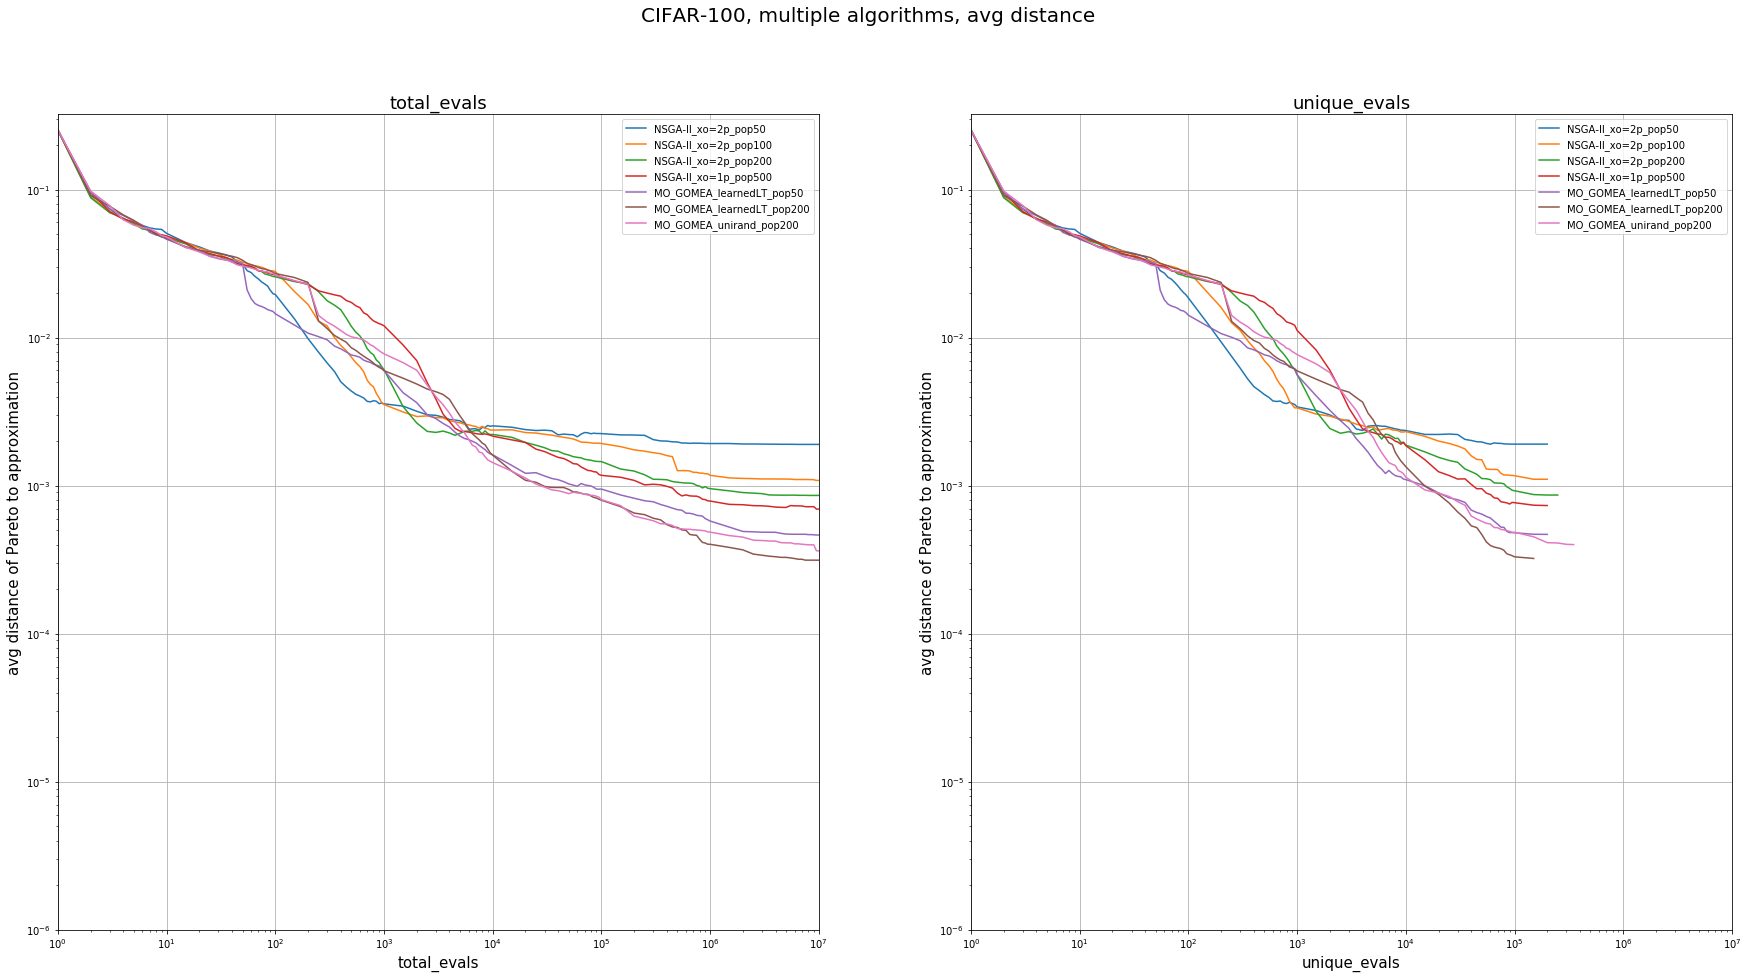

In [53]:
algos = ["NSGA-II_xo=2p_pop50", "NSGA-II_xo=2p_pop100", "NSGA-II_xo=2p_pop200", "NSGA-II_xo=1p_pop500", "MO_GOMEA_learnedLT_pop50", "MO_GOMEA_learnedLT_pop200", "MO_GOMEA_unirand_pop200"]

for distType in ["avg"]: #"max"
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i, evalType in enumerate(["total_evals", "unique_evals"]):
        for algo in algos:
            ax[i].set_xscale("log")
            ax[i].set_yscale("log")
    #         for xo in ["1p", "2p", "3p", "uni", "ark6xo"]:
            plotty(ax[i], "../data/exp18/ARK-7-MO_" + algo + "/", algo, evalType, distType=distType)

            ax[i].set_title(evalType)
            ax[i].set_xlabel(evalType)
            ax[i].set_ylabel(distType+" distance of Pareto to approximation")
            ax[i].set_ylim(pow(10, -6))
            ax[i].set_xlim(1, pow(10, 7))
            ax[i].legend()
        fig.suptitle("CIFAR-100, multiple algorithms, " + distType + " distance")
        ax[i].grid()
    

## Selected algorithms

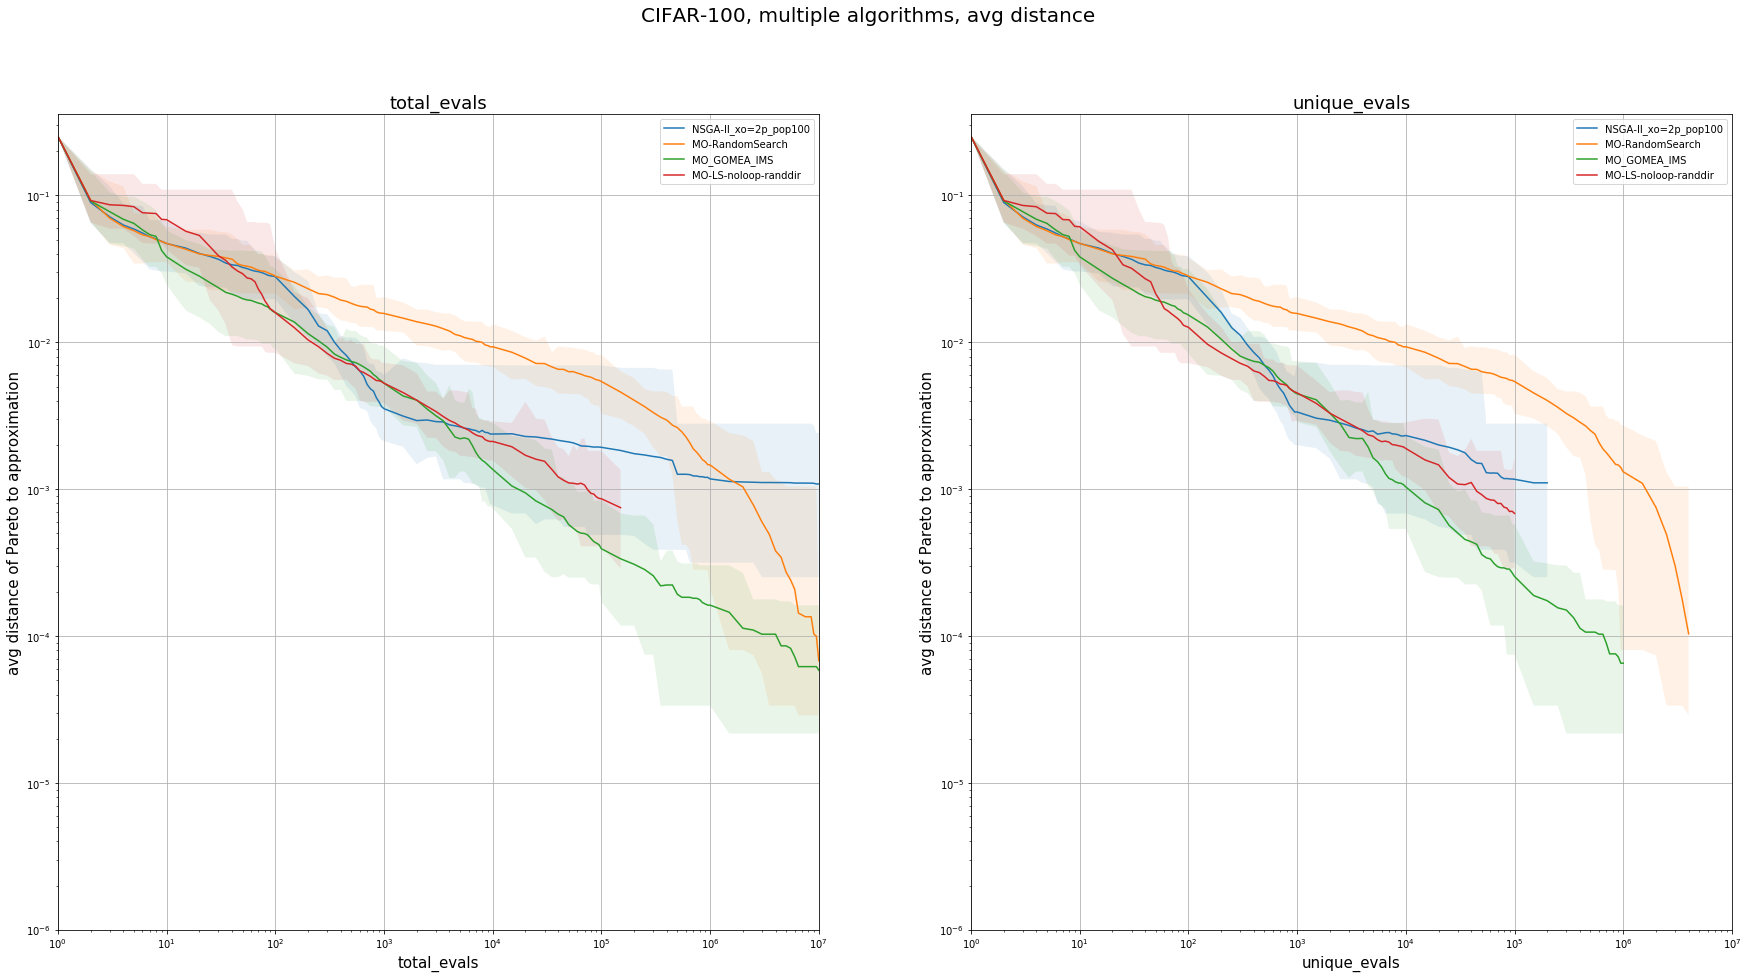

In [54]:
algos = ["NSGA-II_xo=2p_pop100", "MO-RandomSearch", "MO_GOMEA_IMS", "MO-LS-noloop-randdir"] #, "MO-LS"]

for distType in ["avg"]: #"max"
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i, evalType in enumerate(["total_evals", "unique_evals"]):
        for algo in algos:
            ax[i].set_xscale("log")
            ax[i].set_yscale("log")
    #         for xo in ["1p", "2p", "3p", "uni", "ark6xo"]:
            plotty(ax[i], "../data/exp18/ARK-7-MO_" + algo + "/", algo, evalType, distType=distType, minmax=True)

            ax[i].set_title(evalType)
            ax[i].set_xlabel(evalType)
            ax[i].set_ylabel(distType+" distance of Pareto to approximation")
            ax[i].set_ylim(pow(10, -6))
            ax[i].set_xlim(1, pow(10, 7))
            ax[i].legend()
        fig.suptitle("CIFAR-100, multiple algorithms, " + distType + " distance")
        ax[i].grid()
    

### Im not entirely sure, but I think the difference between these is that the MO-LS searches for all-identity, and MO-LS-loop doesn't

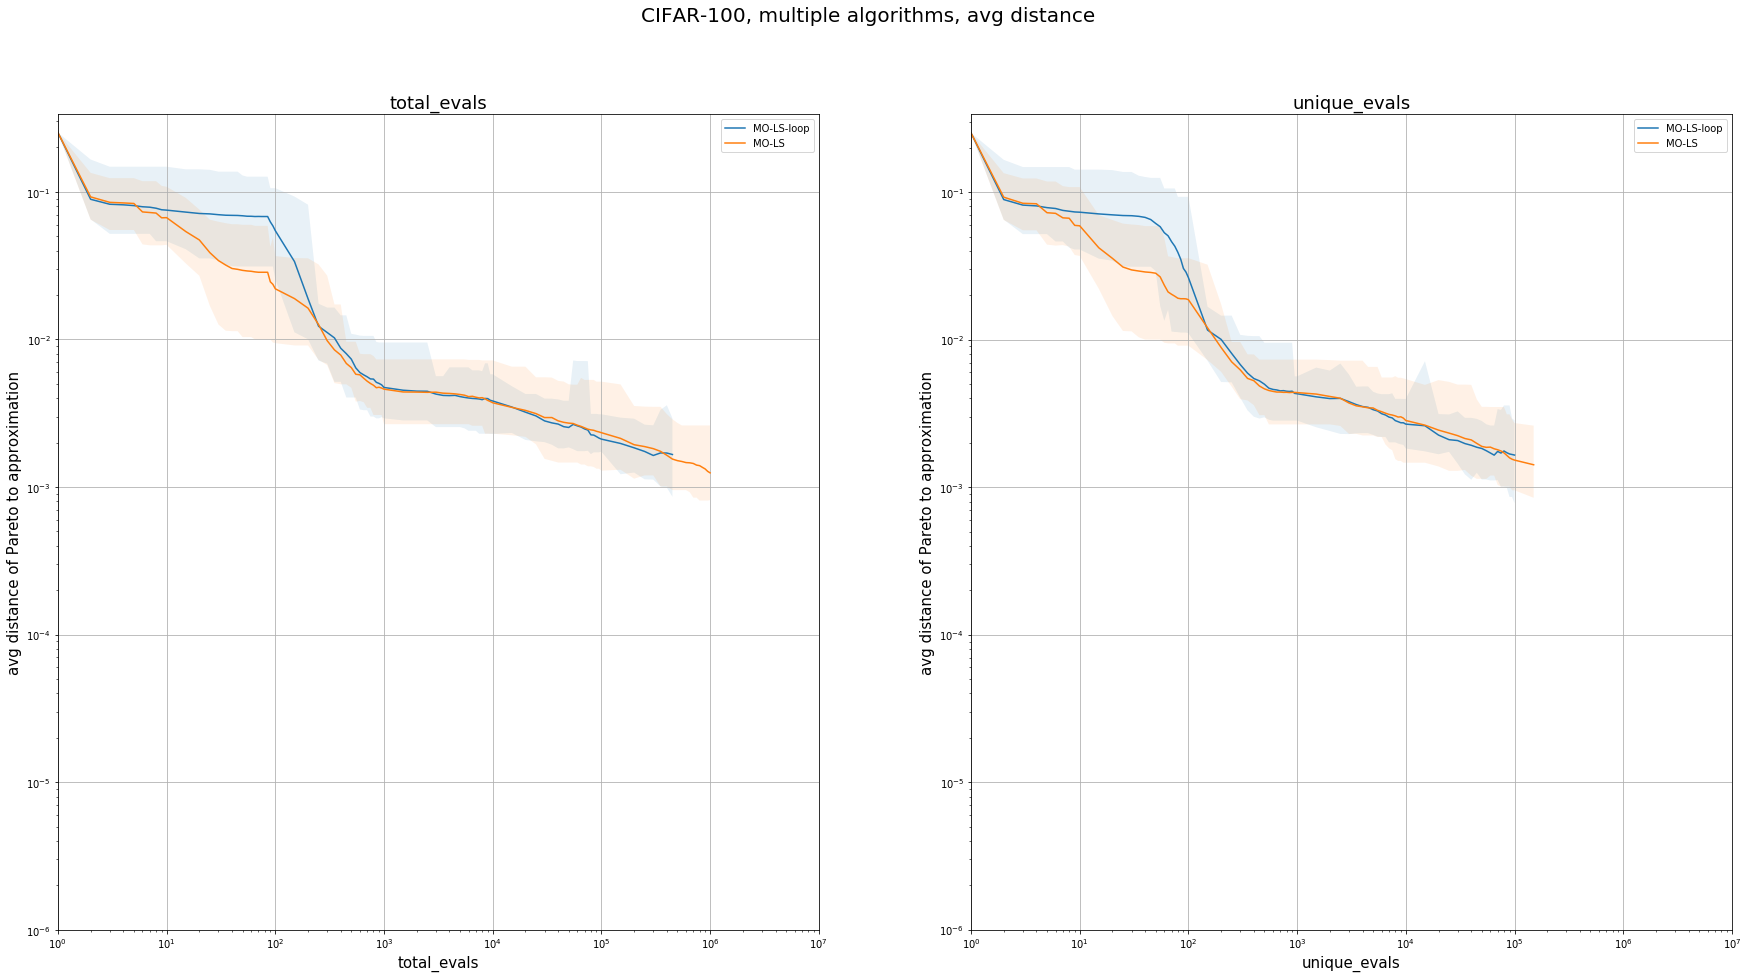

In [55]:
algos = ["MO-LS-loop", "MO-LS"]

for distType in ["avg"]: #"max"
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i, evalType in enumerate(["total_evals", "unique_evals"]):
        for algo in algos:
            ax[i].set_xscale("log")
            ax[i].set_yscale("log")
    #         for xo in ["1p", "2p", "3p", "uni", "ark6xo"]:
            plotty(ax[i], "../data/exp18/old_ARK-7-MO_" + algo + "/", algo, evalType, distType=distType, minmax=True)

            ax[i].set_title(evalType)
            ax[i].set_xlabel(evalType)
            ax[i].set_ylabel(distType+" distance of Pareto to approximation")
            ax[i].set_ylim(pow(10, -6))
            ax[i].set_xlim(1, pow(10, 7))
            ax[i].legend()
        fig.suptitle("CIFAR-100, multiple algorithms, " + distType + " distance")
        ax[i].grid()
    

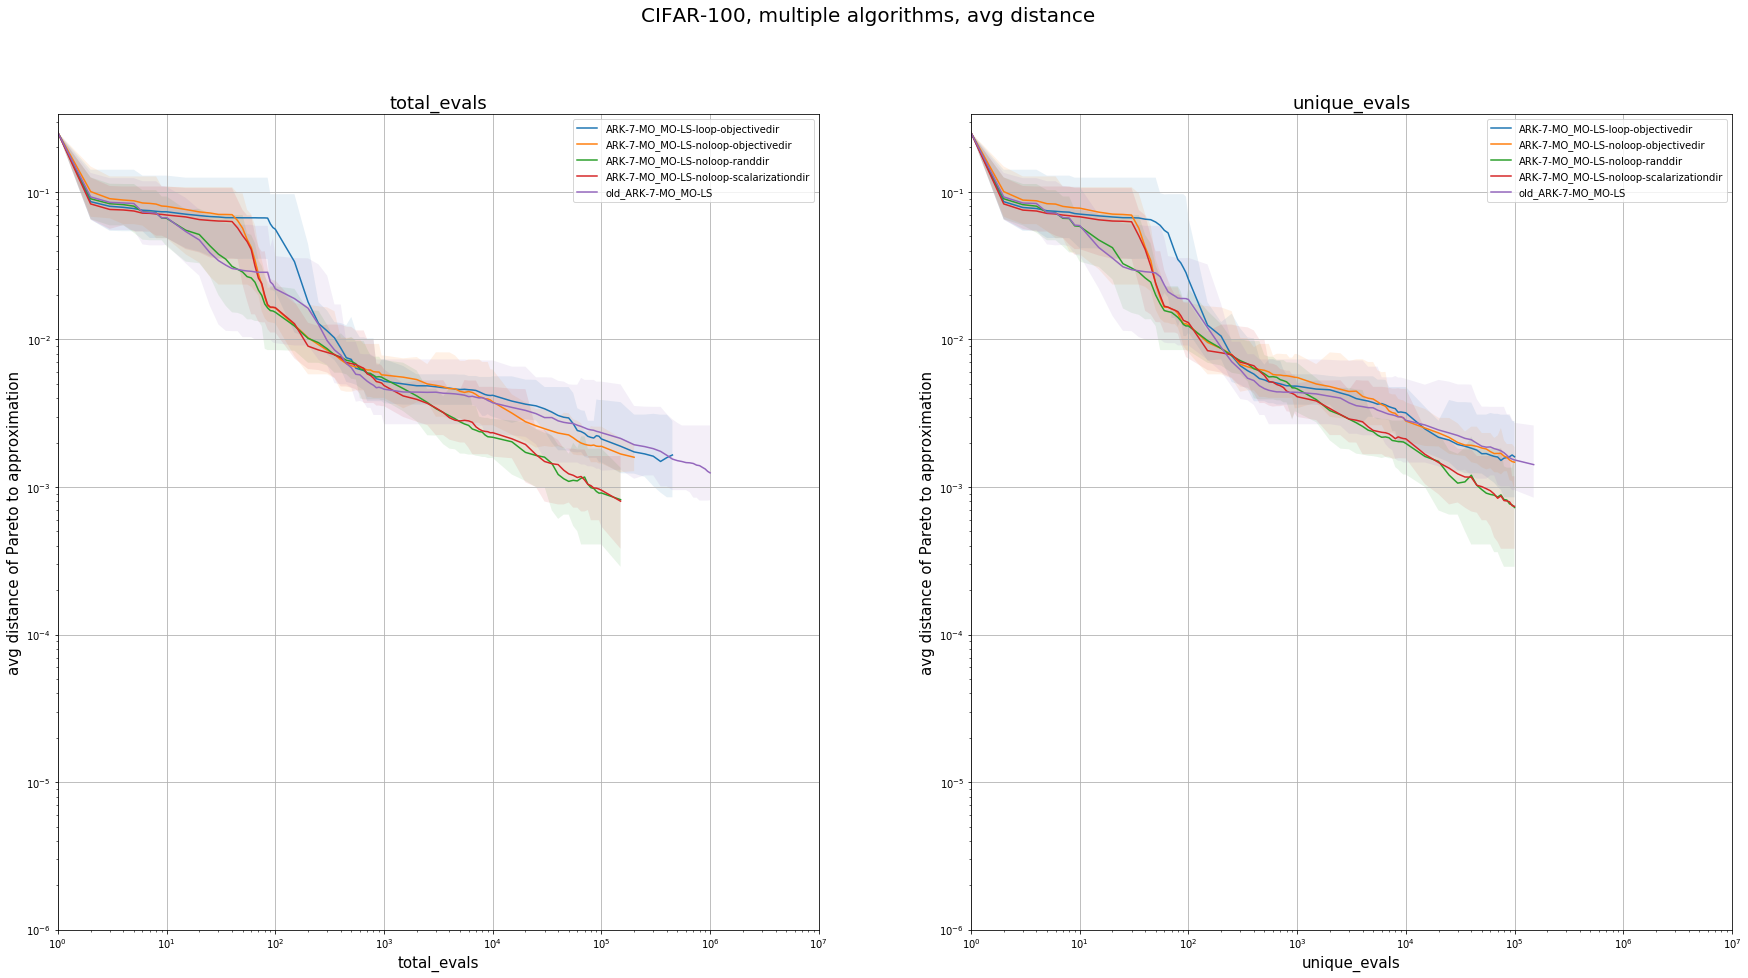

In [61]:
algos = ["ARK-7-MO_MO-LS-loop-objectivedir", "ARK-7-MO_MO-LS-noloop-objectivedir", "ARK-7-MO_MO-LS-noloop-randdir", "ARK-7-MO_MO-LS-noloop-scalarizationdir", "old_ARK-7-MO_MO-LS"]

for distType in ["avg"]: #"max"
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i, evalType in enumerate(["total_evals", "unique_evals"]):
        for algo in algos:
            ax[i].set_xscale("log")
            ax[i].set_yscale("log")
    #         for xo in ["1p", "2p", "3p", "uni", "ark6xo"]:
            plotty(ax[i], "../data/exp18/" + algo + "/", algo, evalType, distType=distType, minmax=True)

            ax[i].set_title(evalType)
            ax[i].set_xlabel(evalType)
            ax[i].set_ylabel(distType+" distance of Pareto to approximation")
            ax[i].set_ylim(pow(10, -6))
            ax[i].set_xlim(1, pow(10, 7))
            ax[i].legend()
        fig.suptitle("CIFAR-100, multiple algorithms, " + distType + " distance")
        ax[i].grid()
    